In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import operator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import timeit
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

palette='Dark2'

%matplotlib inline  

In [72]:
iris_sns = sns.load_dataset('iris')
iris_sns.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [73]:
iris_sns['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [74]:
X = np.array(iris_sns.iloc[:,:-1])
y=np.array(iris_sns.iloc[:,-1])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42)

#### Similarity/distance metric


Euclidean distance

manhanttan distance

Mahalanobis distance

In [75]:
def euclidean_distance(p1,p2):
    if len(p1) != len(p2):
        raise ValueError('Lengths of p1 and p2 must be equal')
    return np.sqrt(
        np.sum(
            (np.array(p1) - np.array(p2))**2
        )
    )

In [76]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
#note that we use fit_transform() for X_train but only transform() for X_test as we want to use same scale transformation for both train and test which is derived based on train data

In [78]:
def get_neighbors(train_set_data_points, test_feature_data_points, k):
    distances=[]
    
    distances.append(
        (train_set_data_points[index], euclidean_distance(test_feature_data_points,train_set_data_points[index],index)) for index in range(len(train_set_data_points))
    )
    #Sort in ascending order
    distances.sort(key=operator.itemgetter(1))
    
    #select k
    neighbors=[distances[index][2] for index in range(k)]
    
    return neighbors
    

In [79]:
#We can also vectorize and merge the distance calc and selecting k neighbors in a single function
def get_neighbors_optimize(train_set, test_set, k):
    #cal euc distance
    euc_distance = np.sqrt(np.sum((train_set - test_set)**2, axis=1))
    #return the index of the neighbors
    return np.argsort(euc_distance)[:k]

In [80]:
def predict_classifier(train_set, train_label, test_set,k):
    #get the index of  all the nearest neighbouring data points
    nearest_data_point_index=get_neighbors_optimize(train_set,test_set,k)
    
    #majority voting
    nearest_data_point_labels = train_label[nearest_data_point_index]
    vote_counts = Counter(nearest_data_point_labels)
    
    #return the class that has most votes
    return max(vote_counts, key=lambda k:vote_counts[k])


In [81]:
def predict_regressor(train_set, train_label, test_set,k):
    #get the index of  all the nearest neighbouring data points
    nearest_data_point_index=get_neighbors_optimize(train_set,test_set,k)

    nearest_data_point_labels = train_label[nearest_data_point_index]
    return np.mean(nearest_data_point_labels)

In [82]:


def get_rmse(y, y_pred):
    mse = np.mean((y - y_pred)**2)
    return round(np.sqrt(mse), 4)

def get_accuracy(y, y_pred):
    #Here equal means it returns 1 if y==y_pred else 0
    cnt = np.equal(y,y_pred).sum()
    return round(cnt/len(y), 2)



In [83]:
#For ease, lets use a class

class Knn():
    def __init__(self,k,weights=None):
        self.k=k
        self.weights=weights

    #We can also vectorize and merge the distance calc and selecting k neighbors in a single function
    def get_neighbors_optimize(self,train_set, test_set, k):
        #cal euc distance
        euc_distance = np.sqrt(np.sum((train_set - test_set)**2, axis=1))
        #return the index of the neighbors
        return np.argsort(euc_distance)[:k]
    
    def fit(self,train_feature, train_label):
        self.train_feature=train_feature
        self.train_label=train_label

In [84]:
class KnnClassifier(Knn):

    def predict(self, test_feature_data_point):
        # get the index of all nearest neighbouring data points
        pred = []
        for i in range(len(test_feature_data_point)):
            nearest_point_index = self.get_neighbors_optimize(self.train_feature, test_feature_data_point[i] , self.k)

            # Majority voting
            nearest_point_labels = self.train_label[nearest_point_index]
            vote_counts = Counter(nearest_point_labels)

            # return the class that has most votes
            pred.append(max(vote_counts, key=lambda k: vote_counts[k]))
        return np.array(pred)

In [85]:
class KnnRegression(Knn):

    def predict(self, test_feature_data_point):
        pred = []
        for i in range(len(test_feature_data_point)):
            nearest_point_index = self.get_neighbors_optimize(self.train_feature, 
                                                               test_feature_data_point[i], self.k)

            # Mean across all neighbours
            nearest_point_labels = self.train_label[nearest_point_index]
            pred.append(np.mean(nearest_point_labels))
        return np.array(pred)

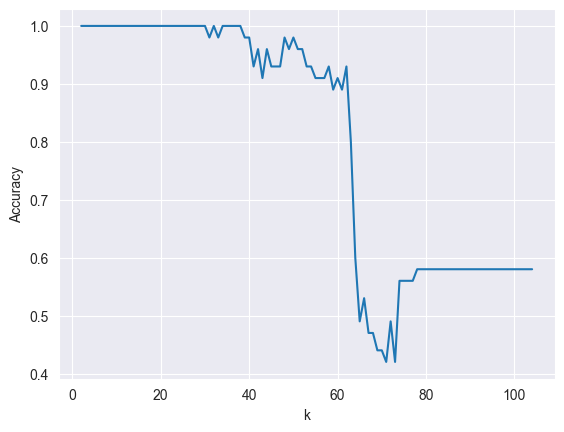

In [86]:
knn_iris_acc = []
for k in range(2, len(X_train)):
    clf = KnnClassifier(k)
    clf.fit(X_train, y_train)
    iri_target_pred = clf.predict(X_test)
    knn_iris_acc.append(get_accuracy(iri_target_pred,y_test))
    
plt.plot(range(2,len(X_train)), knn_iris_acc)
plt.xlabel("k")
plt.ylabel("Accuracy")

plt.show()

In [87]:
#Accuracy is best when k= 2 to 30

In [88]:
#Impact of k on decision boundary

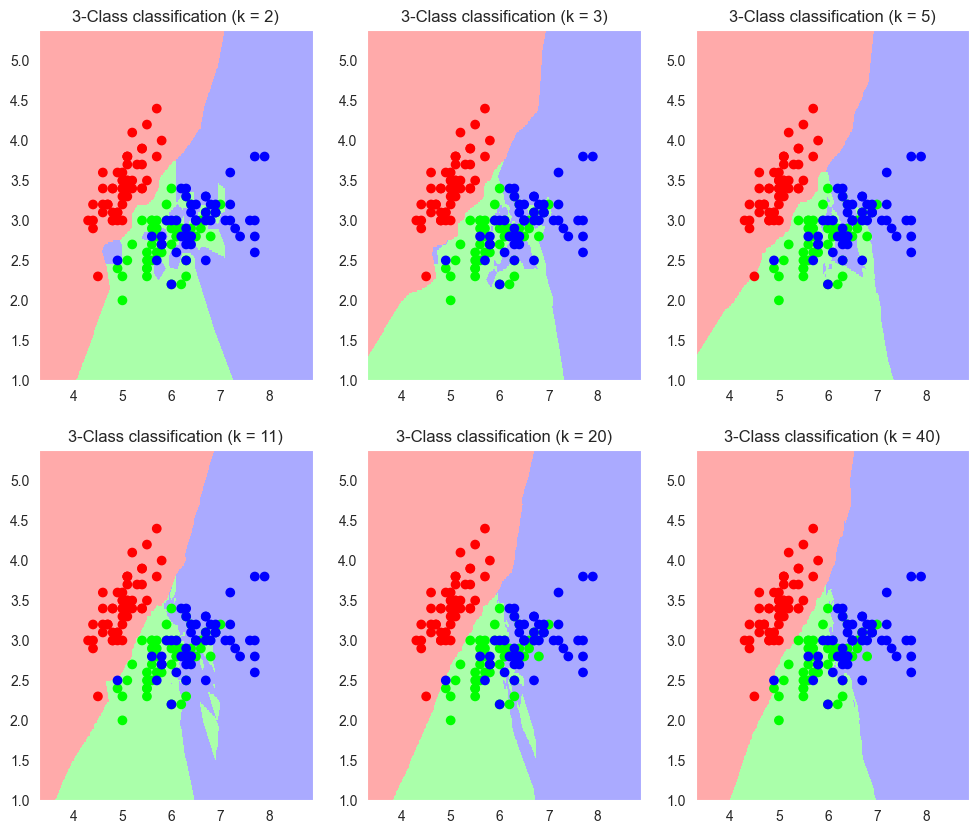

In [93]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = [2,3,5,11,20,40]

iris = datasets.load_iris()
X_train = iris.data[:,:2]
y_train = iris.target

h=.02

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min,x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min,y_max = X_train[:,1].min() -1, X_train[:,1].max()+1

xx, yy = np.meshgrid(
    np.arange(x_min,x_max,h),np.arange(y_min,y_max,h)
)

plt.figure(figsize=(12,10))
for i,k in enumerate(n_neighbors):
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KnnClassifier(k)
    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).flatten()

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.subplot(231+i)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i)"
              % (k))

plt.show()

In [90]:
#Read:
# Inference low k and high k, bias variance tradeoff

In [91]:
#Regression with Knn

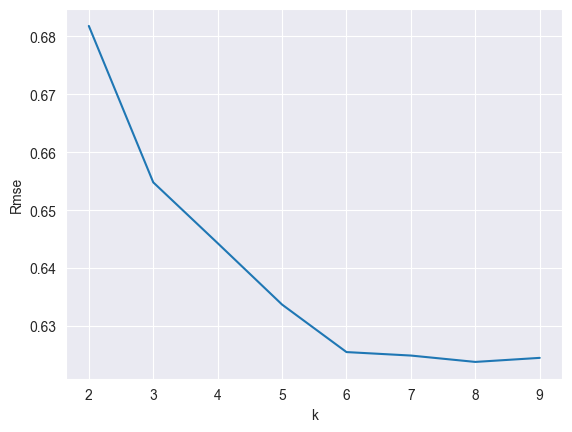

In [94]:
from sklearn.datasets import fetch_california_housing
boston = fetch_california_housing()
boston_rmse = []
X=boston.data
y=boston.target

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)

scale=MinMaxScaler()
X_train=scale.fit_transform(X_train)
X_test=scale.transform(X_test)

knn_boston_rmse =[]

#choose k between 2 to 150
for k in range(2,10):
    reg = KnnRegression(k)
    reg.fit(X_train, y_train)
    boston_pred=[]
    boston_target_pred = reg.predict(X_test)
    boston_rmse.append(get_rmse(boston_target_pred,y_test))

plt.plot(range(2,10),boston_rmse)
plt.xlabel("k")
plt.ylabel("Rmse")
plt.show()

#As k increases, rmse is decreasing